# Compute Multiplier Analysis by Loss

This notebook computes how much less compute model A needs compared to model B to reach the same validation loss value.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from typing import Tuple, Optional
import seaborn as sns


In [3]:
def find_closest_loss_row(
    df: pd.DataFrame, target_loss: float, loss_column: str = "validation_loss"
) -> Tuple[int, float, float]:
    """
    Find the row with validation loss closest to the target loss.

    Args:
        df: DataFrame with training data
        target_loss: Target loss value to find
        loss_column: Name of the loss column to search in

    Returns:
        Tuple of (row_index, actual_loss_found, compute_at_that_point)
    """
    if loss_column not in df.columns:
        raise ValueError(
            f"Column '{loss_column}' not found in DataFrame. Available columns: {list(df.columns)}"
        )

    if "total_flops_profiler" not in df.columns:
        raise ValueError(
            f"Column 'total_flops_profiler' not found in DataFrame. Available columns: {list(df.columns)}"
        )

    # Remove rows with NaN losses
    valid_df = df.dropna(subset=[loss_column])

    if len(valid_df) == 0:
        raise ValueError(f"No valid (non-NaN) values found in {loss_column} column")

    # Find the row with loss closest to target
    loss_differences = np.abs(valid_df[loss_column] - target_loss)
    closest_idx = loss_differences.idxmin()

    actual_loss = valid_df.loc[closest_idx, loss_column]
    compute_value = valid_df.loc[closest_idx, "total_flops_profiler"]

    return closest_idx, actual_loss, compute_value


def compute_multiplier_by_loss(
    csv_file_a: str,
    csv_file_b: str,
    target_loss: float,
    loss_column: str = "validation_loss",
    verbose: bool = True,
) -> Tuple[float, dict]:
    """
    Compute how much less compute model A needs vs model B to reach the same loss.

    Args:
        csv_file_a: Path to first CSV file (model A)
        csv_file_b: Path to second CSV file (model B)
        target_loss: Target loss value to compare at
        loss_column: Name of the loss column (default: 'validation_loss')
        verbose: Whether to print detailed information

    Returns:
        Tuple of (multiplier, details_dict) where:
        - multiplier: compute_B / compute_A (how many times less compute A needs)
        - details_dict: Dictionary with detailed information about the comparison
    """

    try:
        # Read the CSV files
        df_a = pd.read_csv(csv_file_a)
        df_b = pd.read_csv(csv_file_b)

        if verbose:
            print(f"Loaded {csv_file_a}: {len(df_a)} rows")
            print(f"Loaded {csv_file_b}: {len(df_b)} rows")

        # Find closest loss points in both files
        idx_a, loss_a, compute_a = find_closest_loss_row(df_a, target_loss, loss_column)
        idx_b, loss_b, compute_b = find_closest_loss_row(df_b, target_loss, loss_column)

        # Calculate multiplier (how many times less compute A needs vs B)
        multiplier = compute_b / compute_a

        # Prepare detailed results
        details = {
            "target_loss": target_loss,
            "model_a": {
                "file": csv_file_a,
                "closest_row": idx_a,
                "actual_loss": loss_a,
                "compute": compute_a,
                "loss_difference": abs(loss_a - target_loss),
            },
            "model_b": {
                "file": csv_file_b,
                "closest_row": idx_b,
                "actual_loss": loss_b,
                "compute": compute_b,
                "loss_difference": abs(loss_b - target_loss),
            },
            "multiplier": multiplier,
            "compute_ratio_b_to_a": multiplier,
            "percent_compute_reduction": (
                ((multiplier - 1) / multiplier) * 100 if multiplier > 1 else 0
            ),
        }

        if verbose:
            print(f"\nResults for target loss: {target_loss}")
            print("=" * 50)
            print(f"Model A ({csv_file_a}):")
            print(
                f"  Closest loss: {loss_a:.4f} (diff: {abs(loss_a - target_loss):.4f})"
            )
            print(f"  Compute: {compute_a:.2e} FLOPs")
            print(f"  Row index: {idx_a}")

            print(f"\nModel B ({csv_file_b}):")
            print(
                f"  Closest loss: {loss_b:.4f} (diff: {abs(loss_b - target_loss):.4f})"
            )
            print(f"  Compute: {compute_b:.2e} FLOPs")
            print(f"  Row index: {idx_b}")

            print(f"\nCompute Multiplier: {multiplier:.3f}x")
            if multiplier > 1:
                print(
                    f"Model A needs {multiplier:.3f}x LESS compute than Model B to reach loss {target_loss}"
                )
                print(
                    f"Compute reduction: {((multiplier - 1) / multiplier) * 100:.1f}%"
                )
            else:
                print(
                    f"Model A needs {1/multiplier:.3f}x MORE compute than Model B to reach loss {target_loss}"
                )

        return multiplier, details

    except Exception as e:
        print(f"Error computing multiplier: {e}")
        raise


def compare_multiple_loss_points(
    csv_file_a: str,
    csv_file_b: str,
    loss_points: list,
    loss_column: str = "validation_loss",
    plot: bool = True,
) -> pd.DataFrame:
    """
    Compare compute multipliers across multiple loss values.

    Args:
        csv_file_a: Path to first CSV file
        csv_file_b: Path to second CSV file
        loss_points: List of loss values to compare at
        loss_column: Name of the loss column
        plot: Whether to create a plot

    Returns:
        DataFrame with results for each loss point
    """

    results = []

    for target_loss in loss_points:
        try:
            multiplier, details = compute_multiplier_by_loss(
                csv_file_a, csv_file_b, target_loss, loss_column, verbose=False
            )

            results.append(
                {
                    "target_loss": target_loss,
                    "multiplier": multiplier,
                    "model_a_actual_loss": details["model_a"]["actual_loss"],
                    "model_b_actual_loss": details["model_b"]["actual_loss"],
                    "model_a_compute": details["model_a"]["compute"],
                    "model_b_compute": details["model_b"]["compute"],
                    "compute_reduction_percent": details["percent_compute_reduction"],
                }
            )

        except Exception as e:
            print(f"Error at loss {target_loss}: {e}")
            continue

    results_df = pd.DataFrame(results)

    if plot and len(results_df) > 0:
        plt.figure(figsize=(10, 6))
        plt.plot(
            results_df["target_loss"],
            results_df["multiplier"],
            "o-",
            linewidth=2,
            markersize=8,
        )
        plt.xlabel("Target Loss Value")
        plt.ylabel("Compute Multiplier (Model B / Model A)")
        plt.title(f"Compute Efficiency Comparison\n{csv_file_a} vs {csv_file_b}")
        plt.grid(True, alpha=0.3)
        plt.axhline(
            y=1, color="red", linestyle="--", alpha=0.5, label="No difference (1.0x)"
        )

        # Add value labels on points
        for _, row in results_df.iterrows():
            plt.annotate(
                f'{row["multiplier"]:.2f}x',
                (row["target_loss"], row["multiplier"]),
                textcoords="offset points",
                xytext=(0, 10),
                ha="center",
            )

        plt.legend()
        plt.tight_layout()
        plt.show()

    return results_df


def analyze_loss_ranges(
    csv_file_a: str,
    csv_file_b: str,
    num_points: int = 10,
    loss_column: str = "validation_loss",
) -> pd.DataFrame:
    """
    Automatically analyze compute multipliers across the overlapping loss range.

    Args:
        csv_file_a: Path to first CSV file
        csv_file_b: Path to second CSV file
        num_points: Number of loss points to test
        loss_column: Name of the loss column

    Returns:
        DataFrame with results across the loss range
    """

    # Read files to determine overlapping loss range
    df_a = pd.read_csv(csv_file_a)
    df_b = pd.read_csv(csv_file_b)

    # Get valid loss ranges (excluding NaN values)
    valid_losses_a = df_a[loss_column].dropna()
    valid_losses_b = df_b[loss_column].dropna()

    # Find overlapping range
    min_loss_a, max_loss_a = valid_losses_a.min(), valid_losses_a.max()
    min_loss_b, max_loss_b = valid_losses_b.min(), valid_losses_b.max()

    overlap_min = max(min_loss_a, min_loss_b)
    overlap_max = min(max_loss_a, max_loss_b)

    print(f"Loss range overlap: {overlap_min:.3f} to {overlap_max:.3f}")

    if overlap_min >= overlap_max:
        raise ValueError("No overlapping loss range found between the two files")

    # Generate loss points in the overlapping range
    loss_points = np.linspace(overlap_min, overlap_max, num_points)

    return compare_multiple_loss_points(
        csv_file_a, csv_file_b, loss_points, loss_column
    )


In [4]:
target_loss = 5.2
# Example usage and testing
# Example usage - you would replace these with actual file paths
example_file_a = "../experimental_data_folder/alg_mult/64d_swiglu_123.csv"
example_file_b = "../experimental_data_folder/alg_mult/64d_gelu_123.csv"  # hypothetical

multiplier, details = compute_multiplier_by_loss(
    example_file_a,
    example_file_b,  # Using same file for demo
    target_loss,
    verbose=True,
)


# rotary vs sinusoidal


# Example usage and testing
# Example usage - you would replace these with actual file paths
example_file_a = "../experimental_data_folder/alg_mult/64d_rotary_456.csv"
example_file_b = (
    "../experimental_data_folder/alg_mult/64d_sinusoidal_456.csv"  # hypothetical
)

multiplier, details = compute_multiplier_by_loss(
    example_file_a,
    example_file_b,  # Using same file for demo
    target_loss,
    verbose=True,
)

target_loss = 5.5

# Example usage and testing
# Example usage - you would replace these with actual file paths
example_file_a = "../experimental_data_folder/alg_mult/64d_lr_cosine_warmup.csv"
example_file_b = (
    "../experimental_data_folder/alg_mult/64d_lr_inverse_sqrt.csv"  # hypothetical
)

multiplier, details = compute_multiplier_by_loss(
    example_file_a,
    example_file_b,  # Using same file for demo
    target_loss,
    verbose=True,
)

# Example usage and testing
# Example usage - you would replace these with actual file paths
example_file_a = "../experimental_data_folder/alg_mult/64d_rotary_456.csv"
example_file_b = (
    "../experimental_data_folder/alg_mult/64d_sinusoidal_456.csv"  # hypothetical
)

multiplier, details = compute_multiplier_by_loss(
    example_file_a,
    example_file_b,  # Using same file for demo
    target_loss,
    verbose=True,
)

target_loss = 5.1
# Example usage and testing
# Example usage - you would replace these with actual file paths
example_file_a = (
    "../experimental_data_folder/transformer_scaling/swiglu_64d_transformer_bs64.csv"
)
example_file_b = "../experimental_data_folder/debug_historical_experiments/radford_128.csv"  # hypothetical

multiplier, details = compute_multiplier_by_loss(
    example_file_a,
    example_file_b,  # Using same file for demo
    target_loss,
    verbose=True,
)



# trying a diffenret historical run

target_loss = 5.1

# Example usage and testing
# Example usage - you would replace these with actual file paths
example_file_b = "../experimental_data_folder/debug_historical_experiments/radford_64transformer_2018_bs64.csv"
example_file_a = (
    "../experimental_data_folder/modern_scaling_study/64_modern.csv"  # hypothetical
)

multiplier, details = compute_multiplier_by_loss(
    example_file_a,
    example_file_b,  # Using same file for demo
    target_loss,
    verbose=True,
)


target_loss = 5.9

# Example usage and testing
# Example usage - you would replace these with actual file paths
example_file_b = (
    "../experimental_data_folder/historical_experiments/p64transformer_2017_bs64.csv"
)
example_file_a = "../experimental_data_folder/historical_experiments/64transformer_2022_bs64.csv"  # hypothetical

multiplier, details = compute_multiplier_by_loss(
    example_file_a,
    example_file_b,  # Using same file for demo
    target_loss,
    verbose=True,
)


Loaded ../experimental_data_folder/alg_mult/64d_swiglu_123.csv: 135 rows
Loaded ../experimental_data_folder/alg_mult/64d_gelu_123.csv: 135 rows

Results for target loss: 5.2
Model A (../experimental_data_folder/alg_mult/64d_swiglu_123.csv):
  Closest loss: 5.2007 (diff: 0.0007)
  Compute: 1.00e+15 FLOPs
  Row index: 116

Model B (../experimental_data_folder/alg_mult/64d_gelu_123.csv):
  Closest loss: 5.2145 (diff: 0.0145)
  Compute: 1.13e+15 FLOPs
  Row index: 134

Compute Multiplier: 1.130x
Model A needs 1.130x LESS compute than Model B to reach loss 5.2
Compute reduction: 11.5%
Loaded ../experimental_data_folder/alg_mult/64d_rotary_456.csv: 135 rows
Loaded ../experimental_data_folder/alg_mult/64d_sinusoidal_456.csv: 135 rows

Results for target loss: 5.2
Model A (../experimental_data_folder/alg_mult/64d_rotary_456.csv):
  Closest loss: 5.2400 (diff: 0.0400)
  Compute: 1.13e+15 FLOPs
  Row index: 134

Model B (../experimental_data_folder/alg_mult/64d_sinusoidal_456.csv):
  Closest los

In [5]:
# # hello
# # # Updated Generic Stacked Bar Plot Function with Correct Multiplicative Effects


# def create_stacked_comparison_plot(
#     stacked_groups, comparison_data, title="Stacked vs Single Comparison"
# ):
#     """
#     Create a bar plot with multiple stacked bars and multiple single-value bars.
#     Each stacked bar shows cumulative multiplicative effects.

#     Args:
#         stacked_groups: List of lists, where each inner list contains tuples
#                        (name, value, color) for one stacked bar.
#                        Example: [[("A", 1.2, "#fff"), ("B", 1.3, "#eee")],
#                                 [("C", 1.1, "#ddd")]]
#                        This creates 2 stacked bars.
#         comparison_data: List of tuples (name, value, color) for non-stacked comparison bars
#         title: Plot title
#     """

#     # ===== EASILY ADJUSTABLE FONT SIZES =====
#     title_fontsize = 25
#     axis_label_fontsize = 23
#     tick_label_fontsize = 20
#     ytick_label_fontsize = 20  # Added y-axis tick font size
#     legend_fontsize = 20
#     component_label_fontsize = 18
#     value_label_fontsize = 20
#     total_label_fontsize = 18
#     # ========================================

#     # Set seaborn style
#     sns.set_style("whitegrid")
#     sns.set_palette("viridis")

#     # Set up bar positions
#     n_stacked_groups = len(stacked_groups)
#     n_comparison = len(comparison_data)
#     total_bars = n_stacked_groups + n_comparison

#     x_positions = list(range(total_bars))

#     # Create labels for each bar
#     labels = []

#     # Labels for stacked bars
#     for components_data in stacked_groups:
#         stacked_label = "Stacked:\n" + " \n × ".join(
#             [comp[0] for comp in components_data]
#         )
#         labels.append(stacked_label)

#     # Labels for comparison bars
#     comparison_labels = [comp[0] for comp in comparison_data]
#     labels.extend(comparison_labels)

#     plt.figure(figsize=(16, 8))  # Wide figure for two-column layout

#     # Plot each stacked bar group
#     all_max_values = []  # Track all heights for y-axis scaling

#     for bar_idx, components_data in enumerate(stacked_groups):
#         # Calculate cumulative multiplicative heights for this stacked bar
#         cumulative_heights = [0.0]  # Start at 0
#         running_product = 1.0  # Track the running product of multipliers

#         for comp in components_data:
#             multiplier = comp[1]
#             running_product *= multiplier
#             cumulative_heights.append(running_product)

#         total_stacked_height = cumulative_heights[-1]
#         all_max_values.append(total_stacked_height)

#         # Generate viridis colors for components in this bar
#         viridis_colors = sns.color_palette("viridis", n_colors=len(components_data))

#         # Plot stacked components with cumulative multiplicative effects
#         for i, (name, value, color) in enumerate(components_data):
#             bottom = cumulative_heights[i]
#             top = cumulative_heights[i + 1]
#             segment_height = top - bottom

#             # Use viridis colors instead of provided colors
#             viridis_color = viridis_colors[i]
#             bar = plt.bar(
#                 x_positions[bar_idx],
#                 segment_height,
#                 bottom=bottom,
#                 color=viridis_color,
#                 width=0.6,
#                 label=(
#                     f"{name} ({value:.2f}x)" if bar_idx == 0 else ""
#                 ),  # Only label first occurrence
#                 alpha=0.85,
#                 edgecolor="black",
#                 linewidth=0.5,
#             )

#             # Add component labels in the middle of each segment
#             if segment_height > 0.1:  # Only add label if segment is large enough
#                 # Position text in the middle of the segment
#                 text_y = bottom + segment_height / 2

#                 # Ensure text is visible on log scale (at least at y=1.1)
#                 # But only adjust if the segment actually crosses the y=1 threshold
#                 if bottom < 1.0 and text_y < 1.1 and top > 1.0:
#                     text_y = 1.1

#                 plt.text(
#                     x_positions[bar_idx],
#                     text_y,
#                     f"{name}\n{value:.2f}x",
#                     ha="center",
#                     va="center",
#                     fontsize=component_label_fontsize,
#                     fontweight="bold",
#                     color="white" if i % 2 == 0 else "black",
#                 )

#         # Add total height label for this stacked bar
#         plt.text(
#             x_positions[bar_idx],
#             total_stacked_height + 0.2,
#             f"Total: {total_stacked_height:.2f}x",
#             ha="center",
#             va="bottom",
#             fontsize=total_label_fontsize,
#             fontweight="bold",
#             color="black",
#         )

#     # Generate viridis colors for comparison bars
#     comparison_viridis = sns.color_palette("viridis", n_colors=len(comparison_data))

#     # Plot comparison bars
#     for i, (name, value, color) in enumerate(comparison_data):
#         viridis_color = comparison_viridis[i]
#         bar = plt.bar(
#             x_positions[n_stacked_groups + i],
#             value,
#             color=viridis_color,
#             width=0.6,
#             label=f"{name} ({value:.2f}x)",
#             alpha=0.85,
#             edgecolor="black",
#             linewidth=0.5,
#         )

#         all_max_values.append(value)

#         # Add value labels on top
#         plt.text(
#             x_positions[n_stacked_groups + i],
#             value + 0.1,
#             f"{value:.2f}x",
#             ha="center",
#             va="bottom",
#             fontsize=value_label_fontsize,
#             fontweight="bold",
#         )

#     # Customize plot with seaborn styling
#     plt.xticks(
#         x_positions, labels, rotation=0, ha="center", fontsize=tick_label_fontsize
#     )
#     plt.ylabel(
#         "Compute Effect Multiplier", fontsize=axis_label_fontsize, fontweight="bold"
#     )
#     plt.title(title, fontsize=title_fontsize, fontweight="bold")
#     plt.grid(axis="y", linestyle="--", alpha=0.3)
#     plt.yscale("log")

#     # Set y-axis limits
#     max_value = max(all_max_values) if all_max_values else 2.0
#     plt.ylim(1, max_value * 1.4)

#     # Fix y-axis tick font sizes - MUST be done AFTER yscale and ylim
#     ax = plt.gca()

#     # Control the number of y-axis ticks - set explicit tick locations
#     # Adjust these values based on your data range:
#     # Option 1: Minimal ticks (currently active)
#     ax.set_yticks([1, 2])

#     # Remove minor ticks to avoid extra tick marks
#     ax.set_yticks([], minor=True)

#     # Option 2: Show 1, 2, 5 pattern (uncomment to use instead)
#     # ax.set_yticks([1, 2, 5])
#     # ax.set_yticks([], minor=True)

#     # Option 3: Include more values if needed (uncomment to use instead)
#     # ax.set_yticks([1, 1.5, 2, 2.5, 3])
#     # ax.set_yticks([], minor=True)

#     ax.tick_params(axis="y", which="both", labelsize=ytick_label_fontsize)

#     # Add legend below the plot
#     plt.legend(
#         loc="upper center",
#         bbox_to_anchor=(0.5, -0.5),
#         ncol=3,
#         frameon=True,
#         fancybox=True,
#         shadow=True,
#         fontsize=legend_fontsize,
#     )

#     plt.tight_layout()
#     plt.show()

#     # Print summary
#     print(f"\nSummary:")

#     # Print each stacked group
#     for group_idx, components_data in enumerate(stacked_groups):
#         # Recalculate cumulative heights for printing
#         cumulative_heights = [0.0]
#         running_product = 1.0
#         for comp in components_data:
#             running_product *= comp[1]
#             cumulative_heights.append(running_product)

#         total_stacked_height = cumulative_heights[-1]

#         print(f"\nStacked Group {group_idx + 1} - Total: {total_stacked_height:.2f}x")
#         print("  Cumulative breakdown:")
#         for i, (name, value, _) in enumerate(components_data):
#             cumulative = cumulative_heights[i + 1]
#             print(f"    After {name}: {cumulative:.2f}x (×{value:.2f})")

#     if comparison_data:
#         print(f"\nComparison values:")
#         for name, value, _ in comparison_data:
#             print(f"  {name}: {value:.2f}x")



In [6]:
# # Updated Generic Stacked Bar Plot Function with Bar Ordering Support

# def create_stacked_comparison_plot(
#     stacked_groups, 
#     comparison_data, 
#     title="Stacked vs Single Comparison",
#     bar_order=None
# ):
#     """
#     Create a bar plot with multiple stacked bars and multiple single-value bars.
#     Each stacked bar shows cumulative multiplicative effects.

#     Args:
#         stacked_groups: List of lists, where each inner list contains tuples
#                        (name, value, color) for one stacked bar.
#                        Example: [[("A", 1.2, "#fff"), ("B", 1.3, "#eee")],
#                                 [("C", 1.1, "#ddd")]]
#                        This creates 2 stacked bars.
#         comparison_data: List of tuples (name, value, color) for non-stacked comparison bars
#         title: Plot title
#         bar_order: List of tuples specifying exact bar positions
#                    Format: [("stacked", 0), ("comparison", 1), ("stacked", 1), ("comparison", 0)]
#                    - ("stacked", 0) = first stacked group (index 0)
#                    - ("comparison", 1) = second comparison item (index 1)
#                    - ("stacked", 1) = second stacked group (index 1)
#                    - ("comparison", 0) = first comparison item (index 0)
                   
#                    If None, defaults to all stacked groups first, then all comparison items
#     """

#     # ===== EASILY ADJUSTABLE FONT SIZES =====
#     title_fontsize = 25
#     axis_label_fontsize = 23
#     tick_label_fontsize = 20
#     ytick_label_fontsize = 20  # Added y-axis tick font size
#     legend_fontsize = 20
#     component_label_fontsize = 18
#     value_label_fontsize = 20
#     total_label_fontsize = 18
#     # ========================================

#     # Set seaborn style
#     sns.set_style("whitegrid")
#     sns.set_palette("viridis")

#     # Handle bar ordering
#     if bar_order is None:
#         # Default: all stacked groups first, then all comparison items
#         bar_order = [("stacked", i) for i in range(len(stacked_groups))] + \
#                    [("comparison", i) for i in range(len(comparison_data))]

#     # Set up bar positions
#     total_bars = len(bar_order)
#     x_positions = list(range(total_bars))

#     # Create labels for each bar in the specified order
#     labels = []
#     for bar_type, bar_idx in bar_order:
#         if bar_type == "stacked":
#             components_data = stacked_groups[bar_idx]
#             stacked_label = "Stacked:\n" + " \n × ".join(
#                 [comp[0] for comp in components_data]
#             )
#             labels.append(stacked_label)
#         else:  # comparison
#             name, value, color = comparison_data[bar_idx]
#             labels.append(name)

#     plt.figure(figsize=(16, 8))  # Wide figure for two-column layout

#     # Plot bars in the specified order
#     all_max_values = []  # Track all heights for y-axis scaling

#     for plot_idx, (bar_type, bar_idx) in enumerate(bar_order):
#         if bar_type == "stacked":
#             # Plot stacked bar
#             components_data = stacked_groups[bar_idx]
            
#             # Calculate cumulative multiplicative heights for this stacked bar
#             cumulative_heights = [0.0]  # Start at 0
#             running_product = 1.0  # Track the running product of multipliers

#             for comp in components_data:
#                 multiplier = comp[1]
#                 running_product *= multiplier
#                 cumulative_heights.append(running_product)

#             total_stacked_height = cumulative_heights[-1]
#             all_max_values.append(total_stacked_height)

#             # Generate viridis colors for components in this bar
#             viridis_colors = sns.color_palette("viridis", n_colors=len(components_data))

#             # Plot stacked components with cumulative multiplicative effects
#             for i, (name, value, color) in enumerate(components_data):
#                 bottom = cumulative_heights[i]
#                 top = cumulative_heights[i + 1]
#                 segment_height = top - bottom

#                 # Use viridis colors instead of provided colors
#                 viridis_color = viridis_colors[i]
#                 bar = plt.bar(
#                     x_positions[plot_idx],
#                     segment_height,
#                     bottom=bottom,
#                     color=viridis_color,
#                     width=0.6,
#                     label=(
#                         f"{name} ({value:.2f}x)" if plot_idx == 0 else ""
#                     ),  # Only label first occurrence
#                     alpha=0.85,
#                     edgecolor="black",
#                     linewidth=0.5,
#                 )

#                 # Add component labels in the middle of each segment
#                 if segment_height > 0.1:  # Only add label if segment is large enough
#                     # Position text in the middle of the segment
#                     text_y = bottom + segment_height / 2

#                     # Ensure text is visible on log scale (at least at y=1.1)
#                     # But only adjust if the segment actually crosses the y=1 threshold
#                     if bottom < 1.0 and text_y < 1.1 and top > 1.0:
#                         text_y = 1.1

#                     plt.text(
#                         x_positions[plot_idx],
#                         text_y,
#                         f"{name} {value:.2f}x",
#                         ha="center",
#                         va="center",
#                         fontsize=component_label_fontsize,
#                         fontweight="bold",
#                         color="white" if i % 2 == 0 else "black",
#                     )

#             # Add total height label for this stacked bar
#             plt.text(
#                 x_positions[plot_idx],
#                 total_stacked_height + 0.2,
#                 f"Total: {total_stacked_height:.2f}x",
#                 ha="center",
#                 va="bottom",
#                 fontsize=total_label_fontsize,
#                 fontweight="bold",
#                 color="black",
#             )

#         else:  # comparison bar
#             # Plot comparison bar
#             name, value, color = comparison_data[bar_idx]
            
#             # Generate viridis colors for comparison bars
#             comparison_viridis = sns.color_palette("viridis", n_colors=len(comparison_data))
#             viridis_color = comparison_viridis[bar_idx]
            
#             bar = plt.bar(
#                 x_positions[plot_idx],
#                 value,
#                 color=viridis_color,
#                 width=0.6,
#                 label=f"{name} ({value:.2f}x)",
#                 alpha=0.85,
#                 edgecolor="black",
#                 linewidth=0.5,
#             )

#             all_max_values.append(value)

#             # Add value labels on top
#             plt.text(
#                 x_positions[plot_idx],
#                 value + 0.1,
#                 f"{value:.2f}x",
#                 ha="center",
#                 va="bottom",
#                 fontsize=value_label_fontsize,
#                 fontweight="bold",
#             )

#     # Customize plot with seaborn styling
#     plt.xticks(
#         x_positions, labels, rotation=0, ha="center", fontsize=tick_label_fontsize
#     )
#     plt.ylabel(
#         "Compute Effect Multiplier", fontsize=axis_label_fontsize, fontweight="bold"
#     )
#     plt.title(title, fontsize=title_fontsize, fontweight="bold")
#     plt.grid(axis="y", linestyle="--", alpha=0.3)
#     plt.yscale("log")

#     # Set y-axis limits
#     max_value = max(all_max_values) if all_max_values else 2.0
#     plt.ylim(1, max_value * 1.4)

#     # Fix y-axis tick font sizes - MUST be done AFTER yscale and ylim
#     ax = plt.gca()

#     # Control the number of y-axis ticks - set explicit tick locations
#     # Adjust these values based on your data range:
#     # Option 1: Minimal ticks (currently active)
#     ax.set_yticks([1, 2])

#     # Remove minor ticks to avoid extra tick marks
#     ax.set_yticks([], minor=True)

#     # Option 2: Show 1, 2, 5 pattern (uncomment to use instead)
#     # ax.set_yticks([1, 2, 5])
#     # ax.set_yticks([], minor=True)

#     # Option 3: Include more values if needed (uncomment to use instead)
#     # ax.set_yticks([1, 1.5, 2, 2.5, 3])
#     # ax.set_yticks([], minor=True)

#     ax.tick_params(axis="y", which="both", labelsize=ytick_label_fontsize)

#     # Add legend below the plot
#     # plt.legend(
#     #     loc="upper center",
#     #     bbox_to_anchor=(0.5, -0.5),
#     #     ncol=3,
#     #     frameon=True,
#     #     fancybox=True,
#     #     shadow=True,
#     #     fontsize=legend_fontsize,
#     # )

#     plt.tight_layout()
#     plt.show()

#     # Print summary
#     print(f"\nSummary:")

#     # Print each stacked group in the order they appear
#     stacked_group_indices = [bar_idx for bar_type, bar_idx in bar_order if bar_type == "stacked"]
#     for plot_order, group_idx in enumerate(stacked_group_indices):
#         components_data = stacked_groups[group_idx]
        
#         # Recalculate cumulative heights for printing
#         cumulative_heights = [0.0]
#         running_product = 1.0
#         for comp in components_data:
#             running_product *= comp[1]
#             cumulative_heights.append(running_product)

#         total_stacked_height = cumulative_heights[-1]

#         print(f"\nStacked Group {plot_order + 1} (Position {bar_order.index(('stacked', group_idx)) + 1}) - Total: {total_stacked_height:.2f}x")
#         print("  Cumulative breakdown:")
#         for i, (name, value, _) in enumerate(components_data):
#             cumulative = cumulative_heights[i + 1]
#             print(f"    After {name}: {cumulative:.2f}x (×{value:.2f})")

#     # Print comparison values in the order they appear
#     comparison_indices = [bar_idx for bar_type, bar_idx in bar_order if bar_type == "comparison"]
#     if comparison_indices:
#         print(f"\nComparison values:")
#         for plot_order, comp_idx in enumerate(comparison_indices):
#             name, value, _ = comparison_data[comp_idx]
#             position = bar_order.index(('comparison', comp_idx)) + 1
#             print(f"  {name} (Position {position}): {value:.2f}x")



In [17]:
# Fixed version that uses the provided colors instead of viridis

def create_stacked_comparison_plot(
    stacked_groups, 
    comparison_data, 
    title="Stacked vs Single Comparison",
    bar_order=None
):
    """
    Create a bar plot with multiple stacked bars and multiple single-value bars.
    Each stacked bar shows cumulative multiplicative effects.
    NOW USES THE PROVIDED COLORS instead of viridis!
    """

    # ===== EASILY ADJUSTABLE FONT SIZES =====
    title_fontsize = 25
    axis_label_fontsize = 23
    tick_label_fontsize = 20
    ytick_label_fontsize = 20
    legend_fontsize = 20
    component_label_fontsize = 18
    value_label_fontsize = 20
    total_label_fontsize = 18
    # ========================================

    # Set seaborn style
    sns.set_style("whitegrid")
    sns.set_palette("viridis")

    # Handle bar ordering
    if bar_order is None:
        # Default: all stacked groups first, then all comparison items
        bar_order = [("stacked", i) for i in range(len(stacked_groups))] + \
                   [("comparison", i) for i in range(len(comparison_data))]

    # Set up bar positions
    total_bars = len(bar_order)
    x_positions = list(range(total_bars))

    # Create labels for each bar in the specified order
    labels = []
    for bar_type, bar_idx in bar_order:
        if bar_type == "stacked":
            components_data = stacked_groups[bar_idx]
            stacked_label = "Stacked:\n" + " \n × ".join(
                [comp[0] for comp in components_data]
            )
            labels.append(stacked_label)
        else:  # comparison
            name, value, color, *_ = comparison_data[bar_idx]
            labels.append(name)

    plt.figure(figsize=(16, 8))  # Wide figure for two-column layout

    # Plot bars in the specified order
    all_max_values = []  # Track all heights for y-axis scaling

    for plot_idx, (bar_type, bar_idx) in enumerate(bar_order):
        if bar_type == "stacked":
            # Plot stacked bar
            components_data = stacked_groups[bar_idx]
            
            # Calculate cumulative multiplicative heights for this stacked bar
            cumulative_heights = [0.0]  # Start at 0
            running_product = 1.0  # Track the running product of multipliers

            for comp in components_data:
                multiplier = comp[1]
                running_product *= multiplier
                cumulative_heights.append(running_product)

            total_stacked_height = cumulative_heights[-1]
            all_max_values.append(total_stacked_height)

            # Plot stacked components with cumulative multiplicative effects
            for i, comp_data in enumerate(components_data):
                # Unpack with support for optional 5th element (display_name)
                name = comp_data[0]           # Clean name for x-axis labels
                value = comp_data[1]
                color = comp_data[2]
                text_color_val = comp_data[3] if len(comp_data) > 3 else None
                display_name = comp_data[4] if len(comp_data) > 4 else name  # Use display name if provided
                
                bottom = cumulative_heights[i]
                top = cumulative_heights[i + 1]
                segment_height = top - bottom

                # Use the provided color from the data
                bar = plt.bar(
                    x_positions[plot_idx],
                    segment_height,
                    bottom=bottom,
                    color=color,  # Use the provided color
                    width=0.6,
                    label=(
                        f"{name} ({value:.2f}x)" if plot_idx == 0 else ""
                    ),  # Only label first occurrence
                    alpha=0.85,
                    edgecolor="black",
                    linewidth=0.5,
                )

                # Add component labels in the middle of each segment
                if segment_height > 0.1:  # Only add label if segment is large enough
                    # Position text in the middle of the segment
                    text_y = bottom + segment_height / 2

                    # Ensure text is visible on log scale (at least at y=1.1)
                    # But only adjust if the segment actually crosses the y=1 threshold
                    if bottom < 1.0 and text_y < 1.1 and top > 1.0:
                        text_y = 1.1
                    
                    # Use text color from parameters if provided, otherwise alternate black/white
                    text_color_value = text_color_val if text_color_val else ("white" if i % 2 == 0 else "black")

                    plt.text(
                        x_positions[plot_idx],
                        text_y,
                        f"{display_name} {value:.2f}x",  # Use display_name for in-bar text
                        ha="center",
                        va="center",
                        fontsize=component_label_fontsize,
                        fontweight="bold",
                        color=text_color_value,
                    )

            # Add total height label for this stacked bar
            plt.text(
                x_positions[plot_idx],
                total_stacked_height + 0.2,
                f"Total: {total_stacked_height:.2f}x",
                ha="center",
                va="bottom",
                fontsize=total_label_fontsize,
                fontweight="bold",
                color="black",
            )

        else:  # comparison bar
            # Plot comparison bar
            name, value, color, *text_color = comparison_data[bar_idx]
            
            # Use the provided color from the data
            bar = plt.bar(
                x_positions[plot_idx],
                value,
                color=color,  # Use the provided color
                width=0.6,
                label=f"{name} ({value:.2f}x)",
                alpha=0.85,
                edgecolor="black",
                linewidth=0.5,
            )

            all_max_values.append(value)

            # Add value labels on top
            plt.text(
                x_positions[plot_idx],
                value + 0.1,
                f"{value:.2f}x",
                ha="center",
                va="bottom",
                fontsize=value_label_fontsize,
                fontweight="bold",
            )

    # Customize plot with seaborn styling
    plt.xticks(
        x_positions, labels, rotation=0, ha="center", fontsize=tick_label_fontsize
    )
    plt.ylabel(
        "Compute Effect Multiplier", fontsize=axis_label_fontsize, fontweight="bold"
    )
    plt.title(title, fontsize=title_fontsize, fontweight="bold")
    plt.grid(axis="y", linestyle="--", alpha=0.3)
    plt.yscale("log")

    # Set y-axis limits
    max_value = max(all_max_values) if all_max_values else 2.0
    plt.ylim(1, max_value * 1.4)

    # Fix y-axis tick font sizes - MUST be done AFTER yscale and ylim
    ax = plt.gca()

    # Control the number of y-axis ticks - set explicit tick locations
    ax.set_yticks([1, 2])
    ax.set_yticks([], minor=True)
    ax.tick_params(axis="y", which="both", labelsize=ytick_label_fontsize)

    plt.tight_layout()
    plt.show()

    # Print summary
    print(f"\nSummary:")

    # Print each stacked group in the order they appear
    stacked_group_indices = [bar_idx for bar_type, bar_idx in bar_order if bar_type == "stacked"]
    for plot_order, group_idx in enumerate(stacked_group_indices):
        components_data = stacked_groups[group_idx]
        
        # Recalculate cumulative heights for printing
        cumulative_heights = [0.0]
        running_product = 1.0
        for comp in components_data:
            running_product *= comp[1]
            cumulative_heights.append(running_product)

        total_stacked_height = cumulative_heights[-1]

        print(f"\nStacked Group {plot_order + 1} (Position {bar_order.index(('stacked', group_idx)) + 1}) - Total: {total_stacked_height:.2f}x")
        print("  Cumulative breakdown:")
        for i, (name, value, *_) in enumerate(components_data):
            cumulative = cumulative_heights[i + 1]
            print(f"    After {name}: {cumulative:.2f}x (×{value:.2f})")

    # Print comparison values in the order they appear
    comparison_indices = [bar_idx for bar_type, bar_idx in bar_order if bar_type == "comparison"]
    if comparison_indices:
        print(f"\nComparison values:")
        for plot_order, comp_idx in enumerate(comparison_indices):
            name, value, *_ = comparison_data[comp_idx]
            position = bar_order.index(('comparison', comp_idx)) + 1
            print(f"  {name} (Position {position}): {value:.2f}x")


In [18]:
# # Fixed version that uses the provided colors instead of viridis

# def create_stacked_comparison_plot(
#     stacked_groups, 
#     comparison_data, 
#     title="Stacked vs Single Comparison",
#     bar_order=None
# ):
#     """
#     Create a bar plot with multiple stacked bars and multiple single-value bars.
#     Each stacked bar shows cumulative multiplicative effects.
#     NOW USES THE PROVIDED COLORS instead of viridis!
#     """

#     # ===== EASILY ADJUSTABLE FONT SIZES =====
#     title_fontsize = 25
#     axis_label_fontsize = 23
#     tick_label_fontsize = 20
#     ytick_label_fontsize = 20
#     legend_fontsize = 20
#     component_label_fontsize = 18
#     value_label_fontsize = 20
#     total_label_fontsize = 18
#     # ========================================

#     # Set seaborn style
#     sns.set_style("whitegrid")
#     sns.set_palette("viridis")

#     # Handle bar ordering
#     if bar_order is None:
#         # Default: all stacked groups first, then all comparison items
#         bar_order = [("stacked", i) for i in range(len(stacked_groups))] + \
#                    [("comparison", i) for i in range(len(comparison_data))]

#     # Set up bar positions
#     total_bars = len(bar_order)
#     x_positions = list(range(total_bars))

#     # Create labels for each bar in the specified order
#     labels = []
#     for bar_type, bar_idx in bar_order:
#         if bar_type == "stacked":
#             components_data = stacked_groups[bar_idx]
#             stacked_label = "Stacked:\n" + " \n × ".join(
#                 [comp[0] for comp in components_data]
#             )
#             labels.append(stacked_label)
#         else:  # comparison
#             name, value, color = comparison_data[bar_idx]
#             labels.append(name)

#     plt.figure(figsize=(16, 8))  # Wide figure for two-column layout

#     # Plot bars in the specified order
#     all_max_values = []  # Track all heights for y-axis scaling

#     for plot_idx, (bar_type, bar_idx) in enumerate(bar_order):
#         if bar_type == "stacked":
#             # Plot stacked bar
#             components_data = stacked_groups[bar_idx]
            
#             # Calculate cumulative multiplicative heights for this stacked bar
#             cumulative_heights = [0.0]  # Start at 0
#             running_product = 1.0  # Track the running product of multipliers

#             for comp in components_data:
#                 multiplier = comp[1]
#                 running_product *= multiplier
#                 cumulative_heights.append(running_product)

#             total_stacked_height = cumulative_heights[-1]
#             all_max_values.append(total_stacked_height)

#             # Plot stacked components with cumulative multiplicative effects
#             for i, (name, value, color, *text_color) in enumerate(components_data):
#                 bottom = cumulative_heights[i]
#                 top = cumulative_heights[i + 1]
#                 segment_height = top - bottom

#                 # Use the provided color from the data
#                 bar = plt.bar(
#                     x_positions[plot_idx],
#                     segment_height,
#                     bottom=bottom,
#                     color=color,  # Use the provided color
#                     width=0.6,
#                     label=(
#                         f"{name} ({value:.2f}x)" if plot_idx == 0 else ""
#                     ),  # Only label first occurrence
#                     alpha=0.85,
#                     edgecolor="black",
#                     linewidth=0.5,
#                 )

#                 # Add component labels in the middle of each segment
#                 if segment_height > 0.1:  # Only add label if segment is large enough
#                     # Position text in the middle of the segment
#                     text_y = bottom + segment_height / 2

#                     # Ensure text is visible on log scale (at least at y=1.1)
#                     # But only adjust if the segment actually crosses the y=1 threshold
#                     if bottom < 1.0 and text_y < 1.1 and top > 1.0:
#                         text_y = 1.1
                    
#                     # Use text color from parameters if provided, otherwise alternate black/white
#                     text_color_value = text_color[0] if text_color else ("white" if i % 2 == 0 else "black")

#                     plt.text(
#                         x_positions[plot_idx],
#                         text_y,
#                         f"{name} {value:.2f}x",
#                         ha="center",
#                         va="center",
#                         fontsize=component_label_fontsize,
#                         fontweight="bold",
#                         color=text_color_value,
#                     )

#             # Add total height label for this stacked bar
#             plt.text(
#                 x_positions[plot_idx],
#                 total_stacked_height + 0.2,
#                 f"Total: {total_stacked_height:.2f}x",
#                 ha="center",
#                 va="bottom",
#                 fontsize=total_label_fontsize,
#                 fontweight="bold",
#                 color="black",
#             )

#         else:  # comparison bar
#             # Plot comparison bar
#             name, value, color, *text_color = comparison_data[bar_idx] if len(comparison_data[bar_idx]) > 3 else (*comparison_data[bar_idx], None)
            
#             # Use the provided color from the data
#             bar = plt.bar(
#                 x_positions[plot_idx],
#                 value,
#                 color=color,  # Use the provided color
#                 width=0.6,
#                 label=f"{name} ({value:.2f}x)",
#                 alpha=0.85,
#                 edgecolor="black",
#                 linewidth=0.5,
#             )

#             all_max_values.append(value)

#             # Add value labels on top
#             plt.text(
#                 x_positions[plot_idx],
#                 value + 0.1,
#                 f"{value:.2f}x",
#                 ha="center",
#                 va="bottom",
#                 fontsize=value_label_fontsize,
#                 fontweight="bold",
#             )

#     # Customize plot with seaborn styling
#     plt.xticks(
#         x_positions, labels, rotation=0, ha="center", fontsize=tick_label_fontsize
#     )
#     plt.ylabel(
#         "Compute Effect Multiplier", fontsize=axis_label_fontsize, fontweight="bold"
#     )
#     plt.title(title, fontsize=title_fontsize, fontweight="bold")
#     plt.grid(axis="y", linestyle="--", alpha=0.3)
#     plt.yscale("log")

#     # Set y-axis limits
#     max_value = max(all_max_values) if all_max_values else 2.0
#     plt.ylim(1, max_value * 1.4)

#     # Fix y-axis tick font sizes - MUST be done AFTER yscale and ylim
#     ax = plt.gca()

#     # Control the number of y-axis ticks - set explicit tick locations
#     ax.set_yticks([1, 2])
#     ax.set_yticks([], minor=True)
#     ax.tick_params(axis="y", which="both", labelsize=ytick_label_fontsize)

#     plt.tight_layout()
#     plt.show()

#     # Print summary
#     print(f"\nSummary:")

#     # Print each stacked group in the order they appear
#     stacked_group_indices = [bar_idx for bar_type, bar_idx in bar_order if bar_type == "stacked"]
#     for plot_order, group_idx in enumerate(stacked_group_indices):
#         components_data = stacked_groups[group_idx]
        
#         # Recalculate cumulative heights for printing
#         cumulative_heights = [0.0]
#         running_product = 1.0
#         for comp in components_data:
#             running_product *= comp[1]
#             cumulative_heights.append(running_product)

#         total_stacked_height = cumulative_heights[-1]

#         print(f"\nStacked Group {plot_order + 1} (Position {bar_order.index(('stacked', group_idx)) + 1}) - Total: {total_stacked_height:.2f}x")
#         print("  Cumulative breakdown:")
#         for i, (name, value, *_) in enumerate(components_data):
#             cumulative = cumulative_heights[i + 1]
#             print(f"    After {name}: {cumulative:.2f}x (×{value:.2f})")

#     # Print comparison values in the order they appear
#     comparison_indices = [bar_idx for bar_type, bar_idx in bar_order if bar_type == "comparison"]
#     if comparison_indices:
#         print(f"\nComparison values:")
#         for plot_order, comp_idx in enumerate(comparison_indices):
#             name, value, *_ = comparison_data[comp_idx]
#             position = bar_order.index(('comparison', comp_idx)) + 1
#             print(f"  {name} (Position {position}): {value:.2f}x")


In [19]:
# Example usage with placeholder data

# Example 1: 3 stacked components vs 2 comparison bars
# components_data = [
#     ("Adam", 2.5, "#3498db"),
#     ("Rotary", 1.8, "#85C1E9"),
#     ("SwiGLU", 1.4, "#2ECC71"),
# ]

# comparison_data = [
#     ("LSTM Baseline", 1.0, "#e74c3c"),
#     ("Simple Transformer", 3.2, "#f39c12"),
# ]

# create_stacked_comparison_plot(
#     components_data, comparison_data, "Advanced vs Simple Architectures"
# )


# components_data_2 = [
#     ("Rotary Encoding", 1.4, "#9b59b6"),
#     ("SwiGLU", 1.1, "#e67e22"),
#     ("Cosine Scheduler", 1.2, "#1abc9c"),
# ]


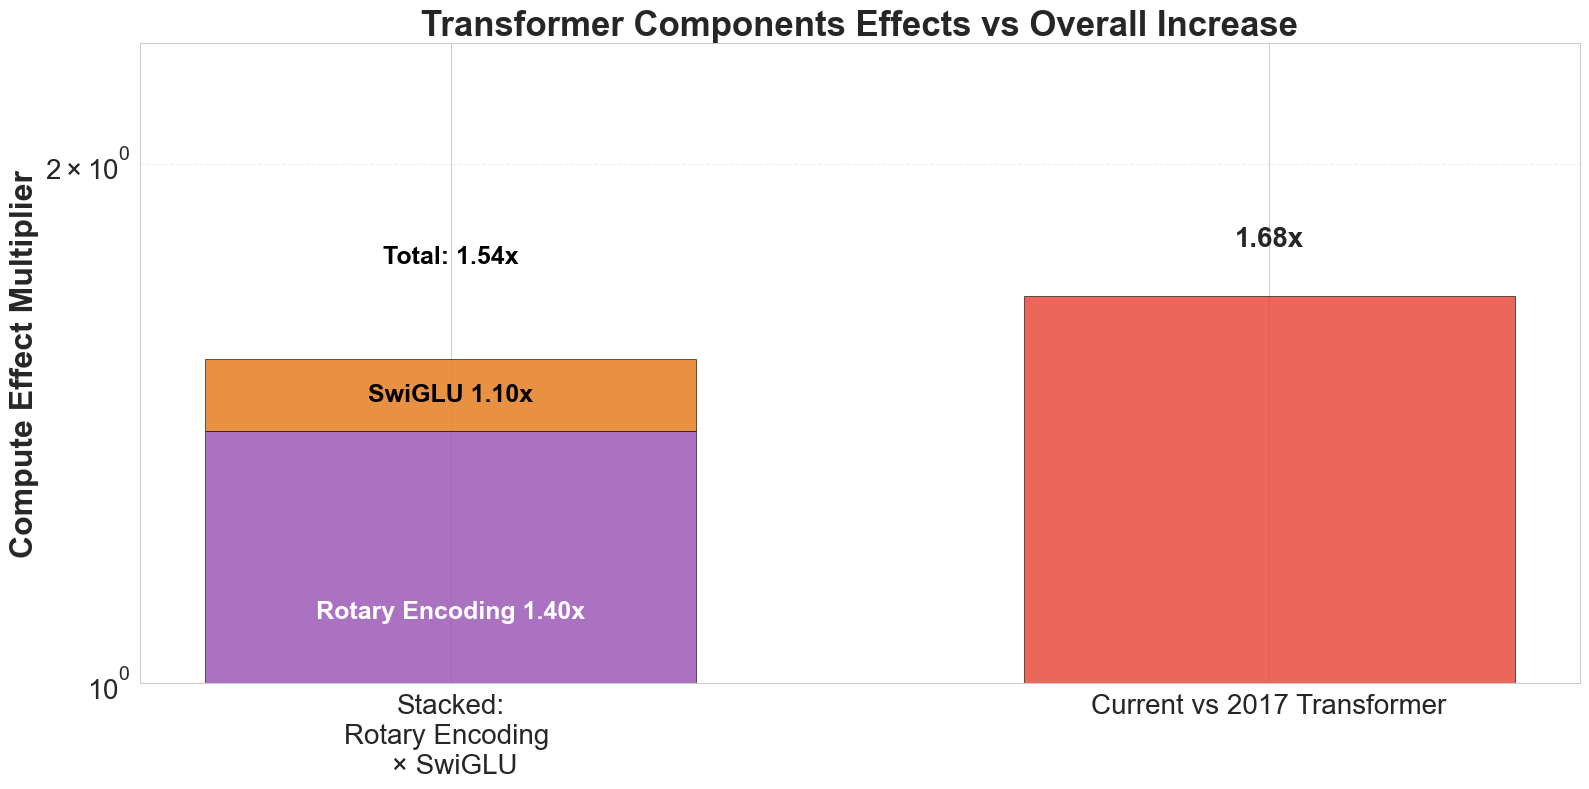


Summary:

Stacked Group 1 (Position 1) - Total: 1.54x
  Cumulative breakdown:
    After Rotary Encoding: 1.40x (×1.40)
    After SwiGLU: 1.54x (×1.10)

Comparison values:
  Current vs 2017 Transformer (Position 2): 1.68x


In [20]:
# Example 2: Multiple stacked bars and multiple comparison bars
# Now you can have multiple stacked groups!

# Define stacked groups - each inner list is one stacked bar
stacked_groups = [
    # First stacked bar: Rotary + SwiGLU
    [
        ("Rotary Encoding", 1.4, "#9b59b6"),
        ("SwiGLU", 1.1, "#e67e22"),
    ],
    # Second stacked bar: Another combination (optional, remove if not needed)
    # [
    #     ("Component A", 1.2, "#1abc9c"),
    #     ("Component B", 1.15, "#3498db"),
    # ],
]

# Define comparison bars - these are single (non-stacked) bars
comparison_data = [
    ("Current vs 2017 Transformer", 1.677, "#e74c3c"),
    # ("Ho et Al", 1.5, "#f39c12"),  # Uncomment to add more comparison bars
]

# This creates: 1 stacked bar (with 2 components) + 1 non-stacked bar = 2 total bars
# To get 4 bars, you could do:
# - 2 stacked groups + 2 comparison bars, OR
# - 1 stacked group + 3 comparison bars, OR
# - 3 stacked groups + 1 comparison bar, etc.

create_stacked_comparison_plot(
    stacked_groups,
    comparison_data,
    "Transformer Components Effects vs Overall Increase",
)


# Bar Plot Examining Interactions

In [21]:
# # Example 3: Create exactly 4 bars (2 stacked + 2 non-stacked)
# stacked_groups_4bars = [
#     # First stacked bar
#     [
#         ("Rotary Encoding", 1.4, "#9b59b6"),
#         ("SwiGLU", 1.1, "#e67e22"),
#     ],
#     # Second stacked bar
#     [
#         ("C", 1.2, "#1abc9c"),
#         ("Component B", 1.3, "#3498db"),
#         ("Component C", 1.1, "#e67e22"),
#     ],
    
# ]

# comparison_data_4bars = [
#     ("Current vs 2017", 1.677, "#e74c3c"),
#     ("Ho et Al", 2.5, "#f39c12"),
# ]

# create_stacked_comparison_plot(
#     stacked_groups_4bars,
#     comparison_data_4bars,
#     "Algorithmic Interaction Investigation",
# )


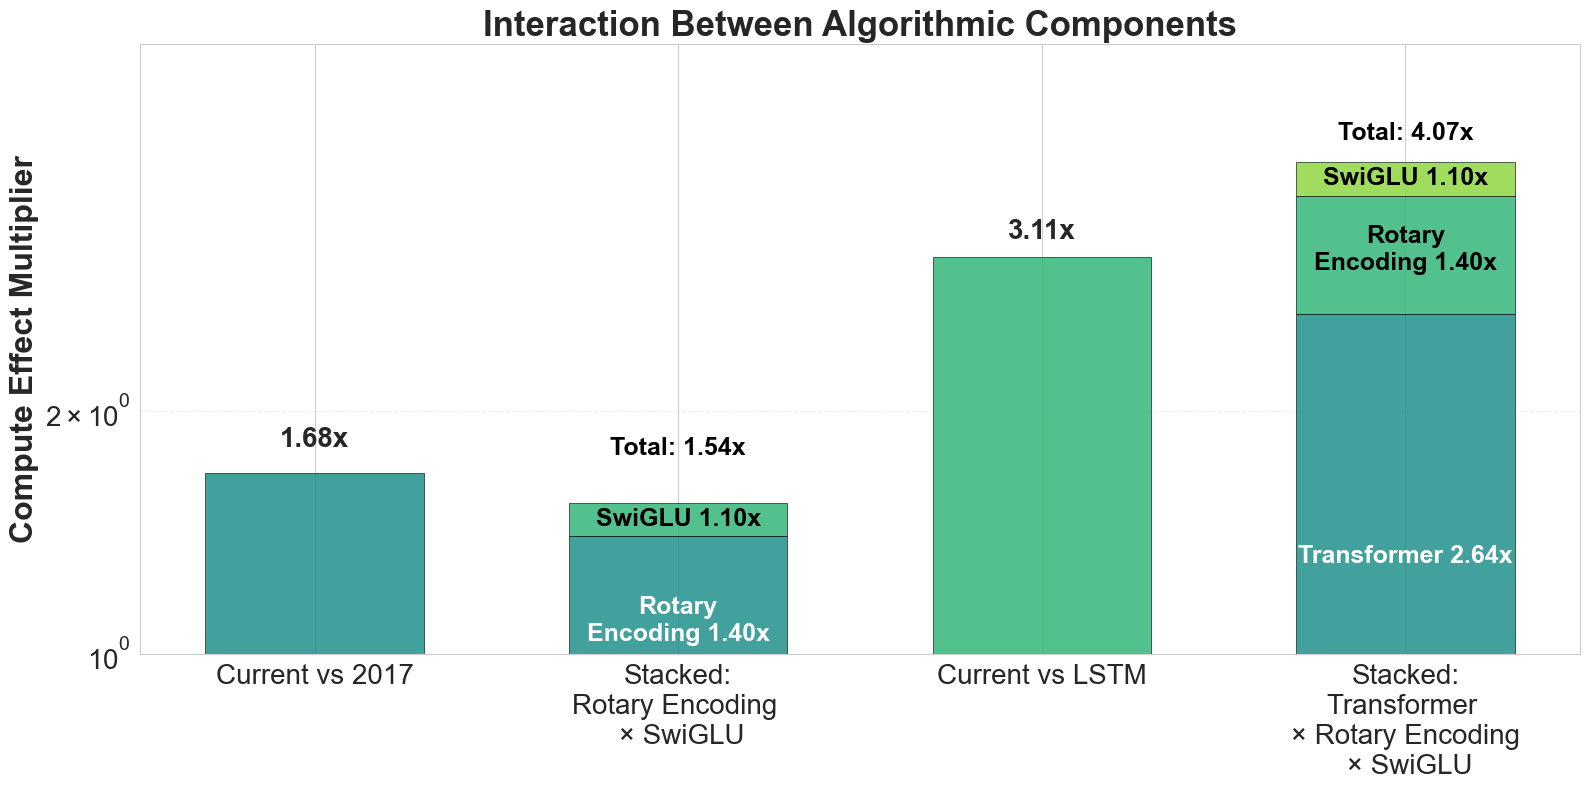


Summary:

Stacked Group 1 (Position 2) - Total: 1.54x
  Cumulative breakdown:
    After Rotary Encoding: 1.40x (×1.40)
    After SwiGLU: 1.54x (×1.10)

Stacked Group 2 (Position 4) - Total: 4.07x
  Cumulative breakdown:
    After Transformer: 2.64x (×2.64)
    After Rotary Encoding: 3.70x (×1.40)
    After SwiGLU: 4.07x (×1.10)

Comparison values:
  Current vs 2017 (Position 1): 1.68x
  Current vs LSTM (Position 3): 3.11x


In [23]:
# Example: Custom bar ordering
# Let's say you want: comparison first, then stacked, then comparison again


# viridis_colors = ["#440154", "#31688e", "#35b779", "#fde725"]  
viridis_colors = sns.color_palette("viridis", n_colors=5)
stacked_groups_custom = [
    # First stacked bar
    # Format: (clean_name, value, color, text_color, display_name)
    [
        ("Rotary Encoding", 1.4, viridis_colors[2], "white", "Rotary\nEncoding"),
        ("SwiGLU", 1.1, viridis_colors[3], "black", "SwiGLU"),
    ],
    # Second stacked bar 
    [
        ("Transformer", 2.642, viridis_colors[2], "white", "Transformer"),
        ("Rotary Encoding", 1.4, viridis_colors[3], "black", "Rotary\nEncoding"),
        ("SwiGLU", 1.1, viridis_colors[4], "black", "SwiGLU"),
    ],
]
# "#e74c3c"


comparison_data_custom = [
    ("Current vs 2017", 1.677, viridis_colors[2], "white"),
    ("Current vs LSTM", 3.109, viridis_colors[3], "black"),
]

# Custom order: comparison first, then stacked, then comparison again
custom_bar_order = [
    ("comparison", 0),    # 1st bar: "Current vs 2017" 
    ("stacked", 0),       # 2nd bar: First stacked group (Rotary + SwiGLU)
    ("comparison", 1),    # 3rd bar: "Ho et Al"
    ("stacked", 1),       # 4th bar: Second stacked group (Component A + Component B)
]

create_stacked_comparison_plot(
    stacked_groups_custom,
    comparison_data_custom,
    "Interaction Between Algorithmic Components",
    bar_order=custom_bar_order
)


# Overall Algorithm Accounting

In [13]:
# # Example 4: 5 stacked components vs 3 comparisons
# components_data_3 = [
#     ("Optimizer", 2.8, '#e74c3c'),
#     ("Architecture", 2.2, '#3498db'),
#     ("Initialization", 1.6, '#2ECC71'),
#     ("Regularization", 1.3, '#f39c12'),
#     ("Data Augmentation", 1.2, '#9b59b6')
# ]

# comparison_data_3 = [
#     ("Baseline", 1.0, '#95a5a6'),
#     ("Partial Improvement", 4.5, '#e67e22'),
#     ("Full Pipeline", 8.2, '#1abc9c')
# ]

# create_stacked_comparison_plot(
#     components_data_3,
#     comparison_data_3,
#     "Complete ML Pipeline Components"
# )


In [14]:
# Orthogonal
